This colab notebook is trying to reproduce the results from the following paper: https://www.nature.com/articles/s41598-022-10841-5#Tab2

The drive below contains the data provided in the paper used for their experiments.

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
%cd /content/drive/My Drive/Phishing_project

/content/drive/My Drive/Phishing_project


# URL content

The data consists of 2 text files consiting of URLs.

The csv file consists of an id, url and label. The label can be 1 represnting a phishing website and -1 representing a non-phishing website.


In [63]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from urllib.parse import urlparse
from tqdm import tqdm
import os

In [64]:
column_names = ['ID', 'URL', 'Label']
id_url = pd.read_csv("ID__URLs_labell.csv", names = column_names)
id_url

,ID,URL,Label
0,id,url,typ
1,5535,10bestbingorooms.com,+1
2,5704,10stepstostartingyouronlinebusiness.com,+1
3,5705,10surdix.com,+1
4,6123,116-region.ru/wp-includes/capitalone360/fe3ffa...,+1
...,...,...,...
60248,439417,drevalair.com/wp-includes/images\t\n,+1
60249,439497,drewwestcott.com/zeta/DROPBOXSECURE/sj/sounds/...,+1
60250,439531,dreyfusashby.com/docs/324/2011/it/\t\n,+1
60251,439532,dreyfusashby.com/italy/\t\n,+1


In [65]:
id_url['Label'] = id_url['Label'].astype(str)
id_url[id_url.Label == "-1"]

,ID,URL,Label
19258,1732185,zoneidc.com,-1
19259,1733848,zqnf.com,-1
19260,1732188,zoneju.com,-1
19261,1732190,zonemaison.com,-1
19262,1735118,zwp-online.info,-1
...,...,...,...
52230,251781,bosch-climate.us,-1
52231,251782,bosch-do-it.com,-1
52232,251785,bosch-garden.com,-1
52233,251805,bosch-presse.de,-1


In [66]:
len(sorted(id_url.URL.unique(), key = lambda x: len(x), reverse = True)[0])

6093

In [67]:
new_row_df = pd.DataFrame([{'ID': "1", 'URL': 'ncbi.nlm.nih.gov/pmc/articles/PMC9936204/', 'Label': "0"}, {'ID': "3", 'URL': 'https://www.reddit.com/r/resumes/', 'Label': "0"}, {'ID': "2", 'URL': 'nvidia.com/en-us/account/login-gate/', 'Label': "0"}])
id_url = pd.concat([id_url, new_row_df], ignore_index=True)

In [70]:
id_url[id_url.ID == "3"]

,ID,URL,Label
60254,3,https://www.reddit.com/r/resumes/,0


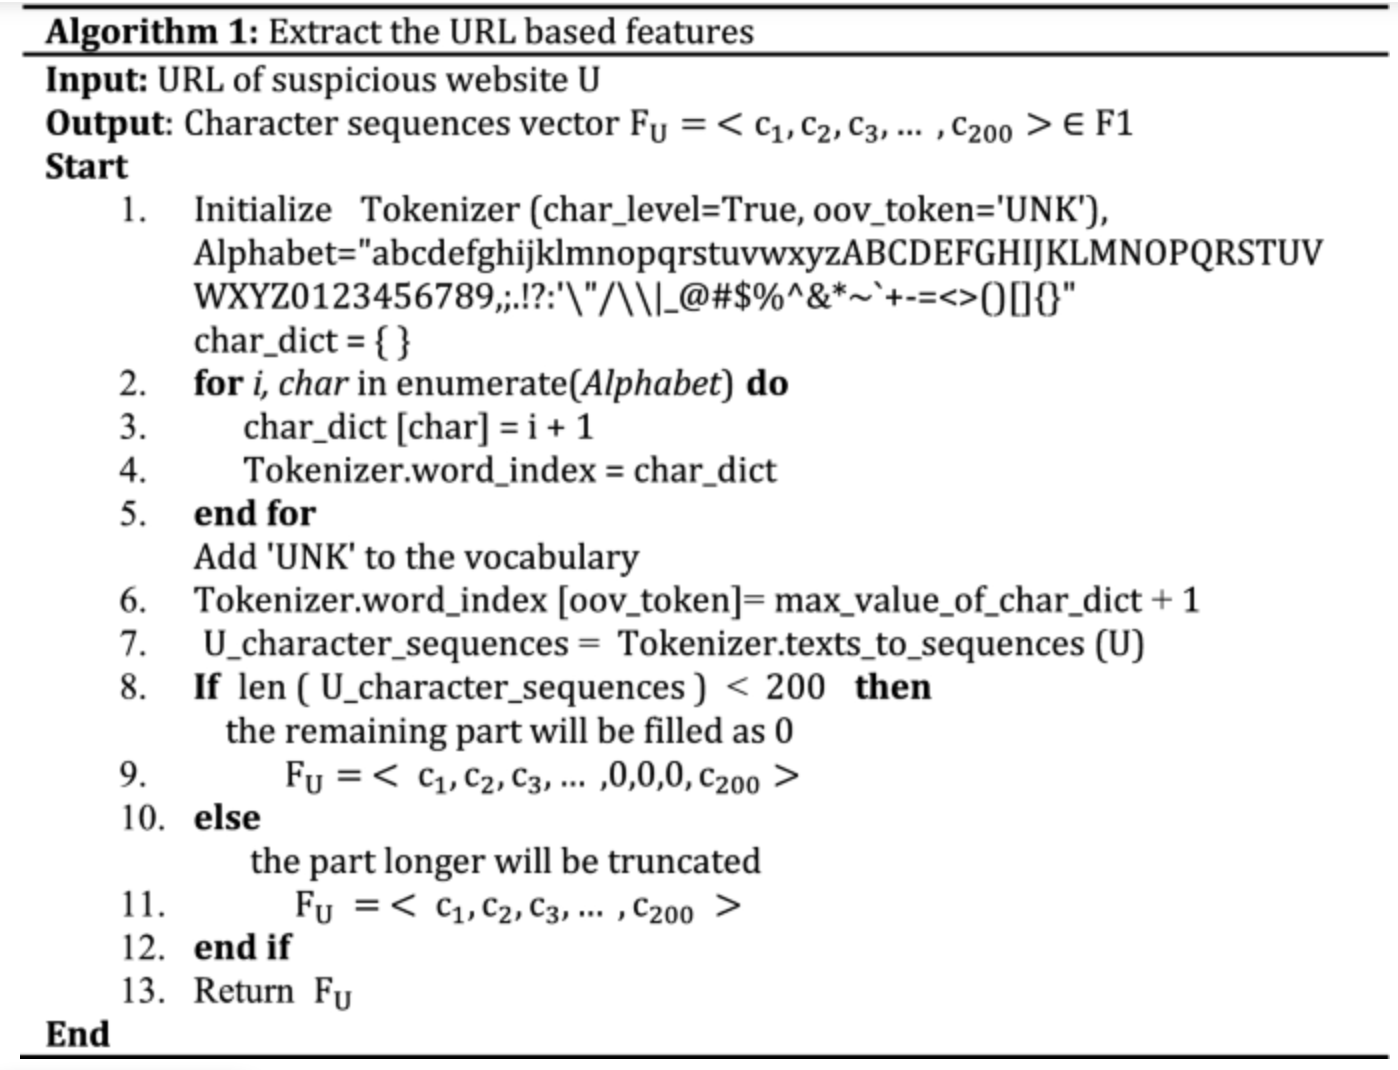

In [ ]:
tokenizer = Tokenizer(char_level=True, oov_token='UNK')

alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"

char_dict = {char: i + 1 for i, char in enumerate(alphabet)}
tokenizer.word_index = char_dict

tokenizer.word_index[tokenizer.oov_token] = len(char_dict.values()) + 1

In [ ]:
# If you need to return the sequences, you can do so
def extract_url_features(url, max_length=200):
  sequences = tokenizer.texts_to_sequences([url])
  padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
  return padded_sequences[0]

# Example usage
a = [str(a) for a in id_url['URL'].values]
f1 = []
for b in a:
  f1.append(extract_url_features(b))

f1

# HTML Content

The basic of this step is to extract the vectored representation of the text and the effective webpage content.


A TF-IDF object is employed to vectorize text of the webpage.

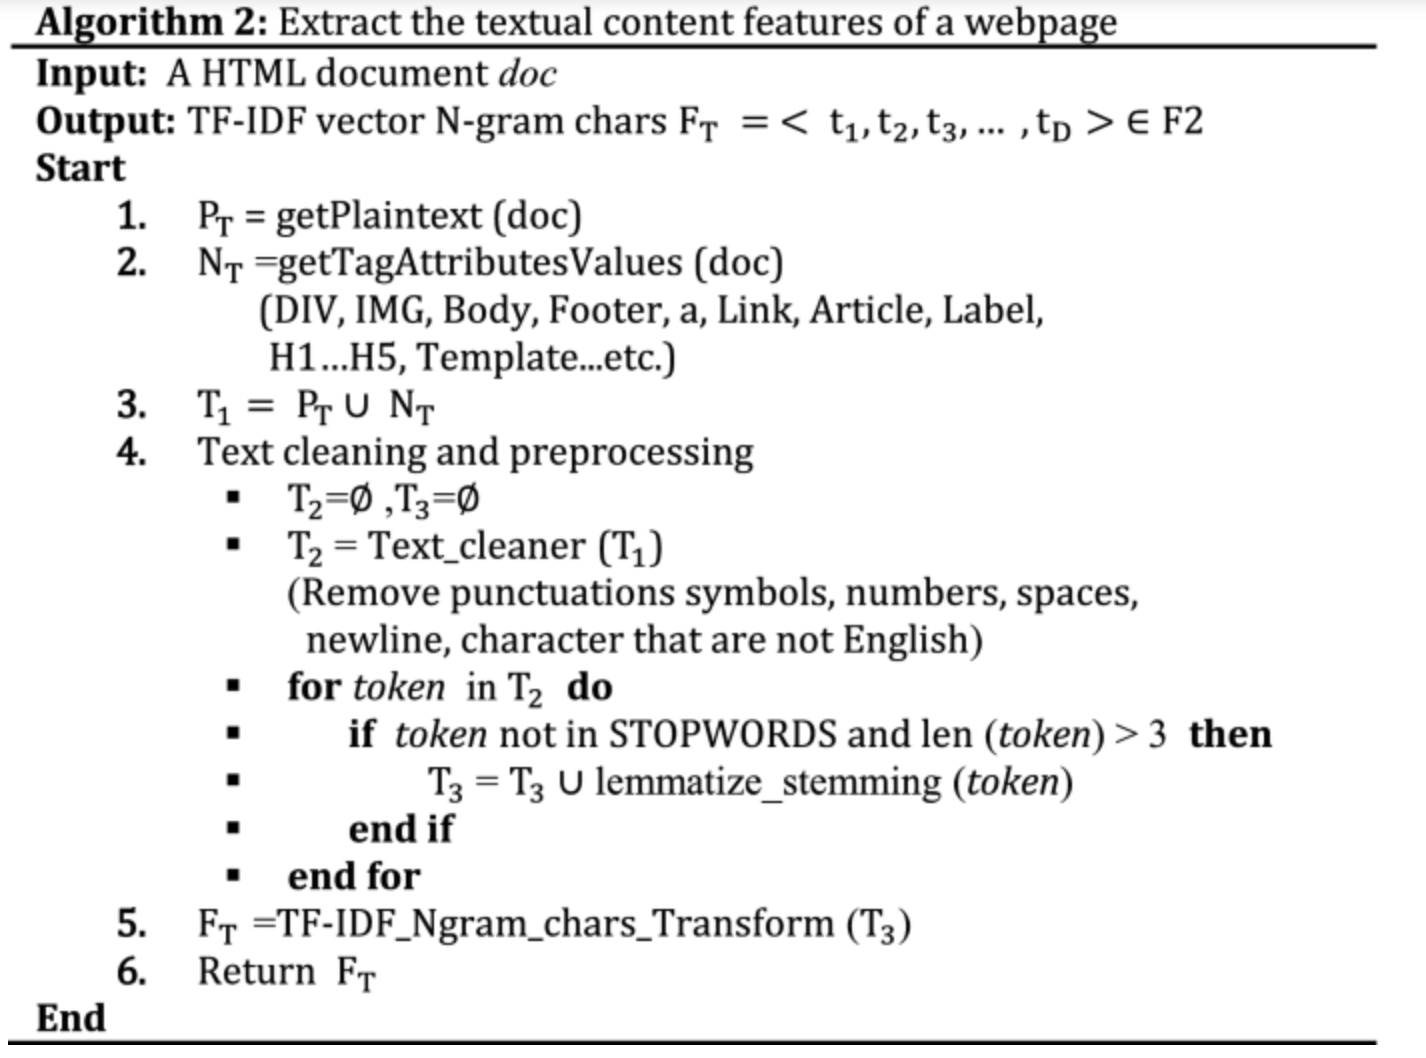

**Psuedocode:**

get text from file

get tag values from file

**combine** the 2 -> cs

**clean** the **combined stuff**(nltk) --> ccs

var for **lemmitized & Stemmed clean combined stuff**
---> lsccs  

for each val in combined_stuff  
  if "val" != stopword and > 3  
      then lccs combine lemmitize(val)  

tranform into TFIDF
give back the TFIDF Mat -> f_t

In [ ]:
#getPlainText(doc)
def getPlaintext(doc):
  soup = BeautifulSoup(doc, 'html.parser')
  return soup.get_text(separator=' ')

In [ ]:
#getTagAttributeValues(doc)
def getTagAttributesValues(doc):
  soup = BeautifulSoup(doc, 'html.parser')
  tags = ['div', 'img', 'body', 'footer', 'a', 'link', 'article', 'label', 'h1', 'h2', 'h3', 'h4', 'h5', 'template',
    'span', 'section', 'nav', 'header', 'aside', 'p', 'ul', 'ol', 'li', 'table', 'thead', 'tbody', 'tr', 'td',
    'form', 'input', 'button', 'select', 'option', 'textarea', 'strong', 'em', 'i', 'b', 'u', 'iframe', 'blockquote']
  attr_values = []
  for tag in tags:
    elements = soup.find_all(tag)
    for element in elements:
      for attr in element.attrs.values():
        if isinstance(attr, list):
          attr_values.extend(attr)
        else:
          attr_values.append(attr)
  return ' '.join(attr_values)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def extracting_stuff(doc):
  text = getPlaintext(doc)
  attr = getTagAttributesValues(doc)
  c_s = text + ' ' + attr
  c_c_s = re.sub(r'[^a-zA-Z\s]', '', c_s).lower()
  tokens = c_c_s.split()
  l_s_c_c_s = []
  for token in tokens:
    if token not in stopwords and len(token) > 3:
      token = lemmatizer.lemmatize(token)
      token = stemmer.stem(token)
      l_s_c_c_s.append(token)
  l_s_c_c_s = ' '.join(l_s_c_c_s)

  if not l_s_c_c_s.strip():
    return None  # Return None if there are no valid tokens

  vectorizer = TfidfVectorizer(ngram_range=(1, 3))
  F_T = vectorizer.fit_transform([l_s_c_c_s])
  return F_T

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def process(directory):
    all_features = []
    files = [f for f in os.listdir(directory) if f.endswith(".txt")]
    for i in tqdm(files, desc="Processing files"):
        filepath = os.path.join(directory, i)
        with open(filepath, 'r', encoding='utf-8') as file:
            html_doc = file.read()
            features = extracting_stuff(html_doc)
            if features is not None:  # Skip documents that have no valid tokens
              all_features.append(features)
    return all_features

dir = '/content/drive/My Drive/Phishing_project/sourc_Data(D1)'
all_features = process(dir)  # ---------> F2

# Print the features of the first document
print(all_features[0])

Processing files:  98%|█████████▊| 59430/60456 [5:55:41<05:35,  3.06it/s]

Processing files: 100%|██████████| 12/12 [00:07<00:00,  1.70it/s]

  (0, 8)	0.04428074427700476
  (0, 159)	0.04428074427700476
  (0, 147)	0.04428074427700476
  (0, 144)	0.04428074427700476
  (0, 180)	0.04428074427700476
  (0, 149)	0.04428074427700476
  (0, 182)	0.04428074427700476
  (0, 161)	0.04428074427700476
  (0, 228)	0.04428074427700476
  (0, 220)	0.04428074427700476
  (0, 223)	0.08856148855400953
  (0, 63)	0.08856148855400953
  (0, 226)	0.08856148855400953
  (0, 219)	0.08856148855400953
  (0, 60)	0.1328422328310143
  (0, 139)	0.04428074427700476
  (0, 152)	0.04428074427700476
  (0, 141)	0.04428074427700476
  (0, 153)	0.04428074427700476
  (0, 244)	0.08856148855400953
  (0, 108)	0.08856148855400953
  (0, 118)	0.08856148855400953
  (0, 166)	0.08856148855400953
  (0, 127)	0.08856148855400953
  (0, 100)	0.04428074427700476
  :	:
  (0, 119)	0.04428074427700476
  (0, 49)	0.04428074427700476
  (0, 46)	0.04428074427700476
  (0, 43)	0.04428074427700476
  (0, 67)	0.08856148855400953
  (0, 194)	0.04428074427700476
  (0, 37)	0.04428074427700476
  (0, 11)	0.

In [ ]:
# OLD code with matrix of all docs combined
'''
def extracting_stuff(doc):
  text = getPlaintext(doc)
  attr = getTagAttributesValues(doc)
  c_s = text + ' ' + attr
  c_c_s = re.sub(r'[^a-zA-Z\s]', '', c_s).lower()
  tokens = c_c_s.split()
  l_s_c_c_s = []
  for token in tokens:
    if token not in stopwords and len(token) > 3:
      token = lemmatizer.lemmatize(token)
      token = stemmer.stem(token)
      l_s_c_c_s.append(token)
  return ' '.join(l_s_c_c_s)

def process(dir):
  documents = []
  for i in os.listdir(dir):
    if i.endswith(".txt"):
      filepath = os.path.join(dir, i)
      with open(filepath, 'r', encoding='utf-8') as file:
        html_doc = file.read()
        features = extracting_stuff(html_doc)
        documents.append(features)
  vectorizer = TfidfVectorizer(ngram_range=(1, 3))
  tfidf_matrix = vectorizer.fit_transform(documents)
  return tfidf_matrix, vectorizer.get_feature_names_out()

dir = '/content/drive/My Drive/Phishing_project/test'  # when actually running will have to chnage it to sourc_Data(D1)
tfidf_matrix, feature_names = process(dir)

print("Feature names:", feature_names)
print("TF-IDF matrix shape:", tfidf_matrix.shape)
print("TF-IDF matrix:\n", tfidf_matrix.toarray())

'''

# Script, CSS, img, and anchor files (F3, F4, F5, and F6), Empty hyperlinks (F7 and F8)


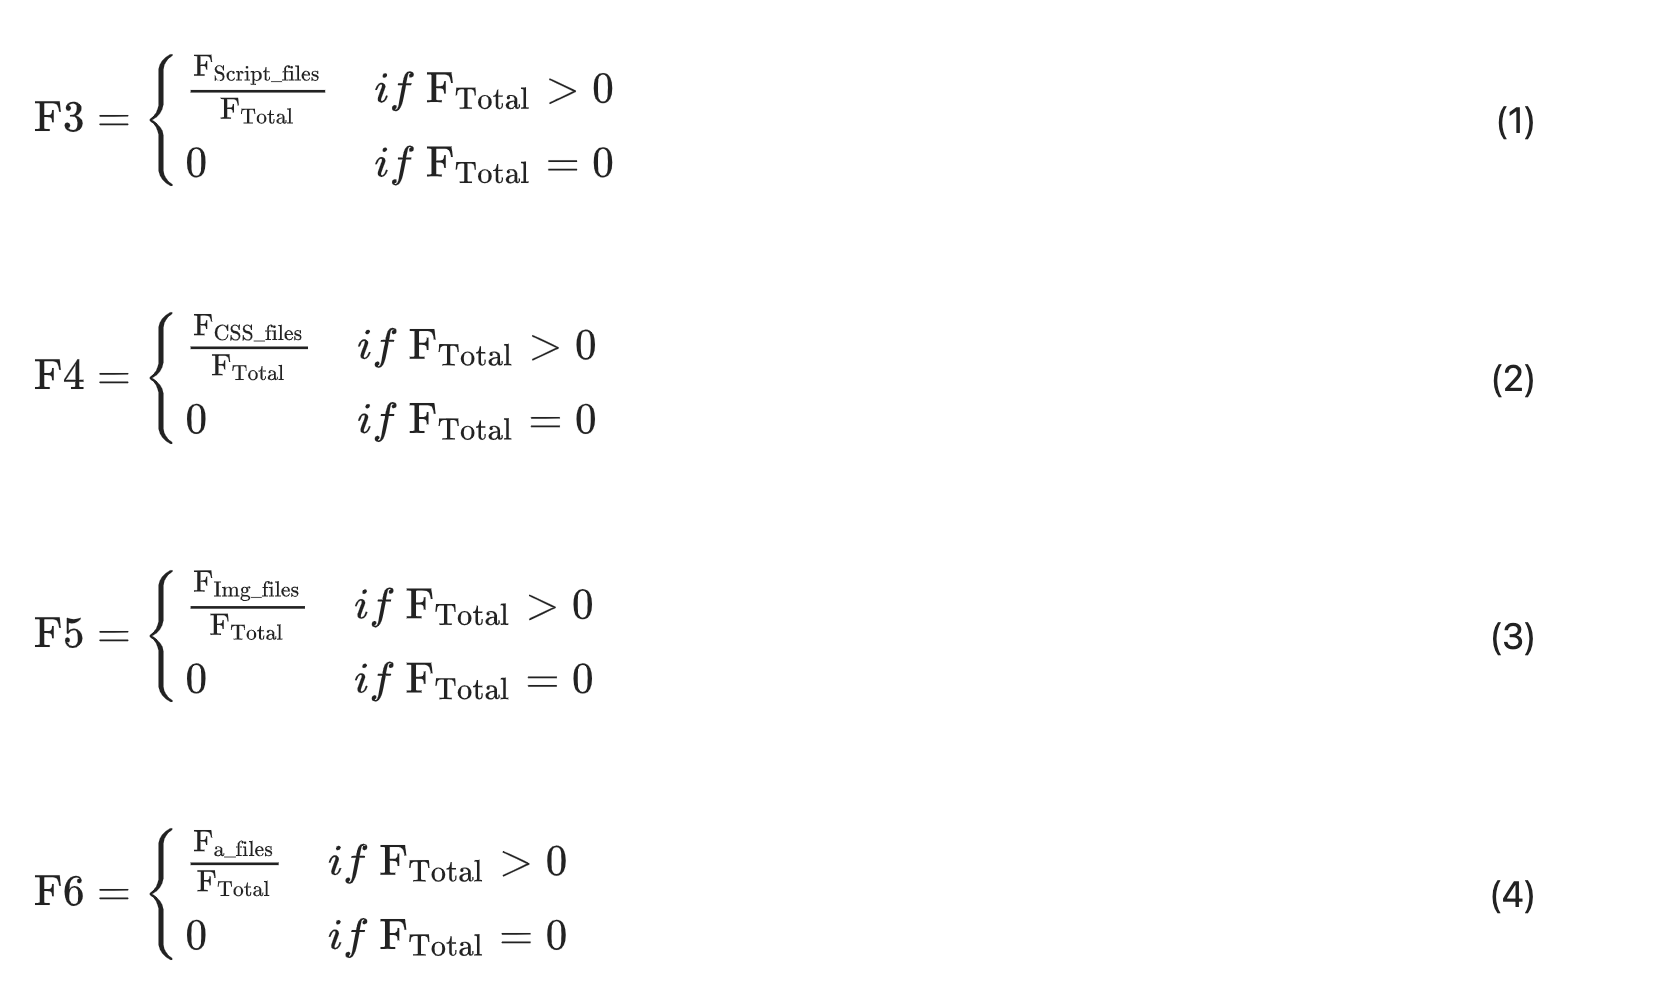

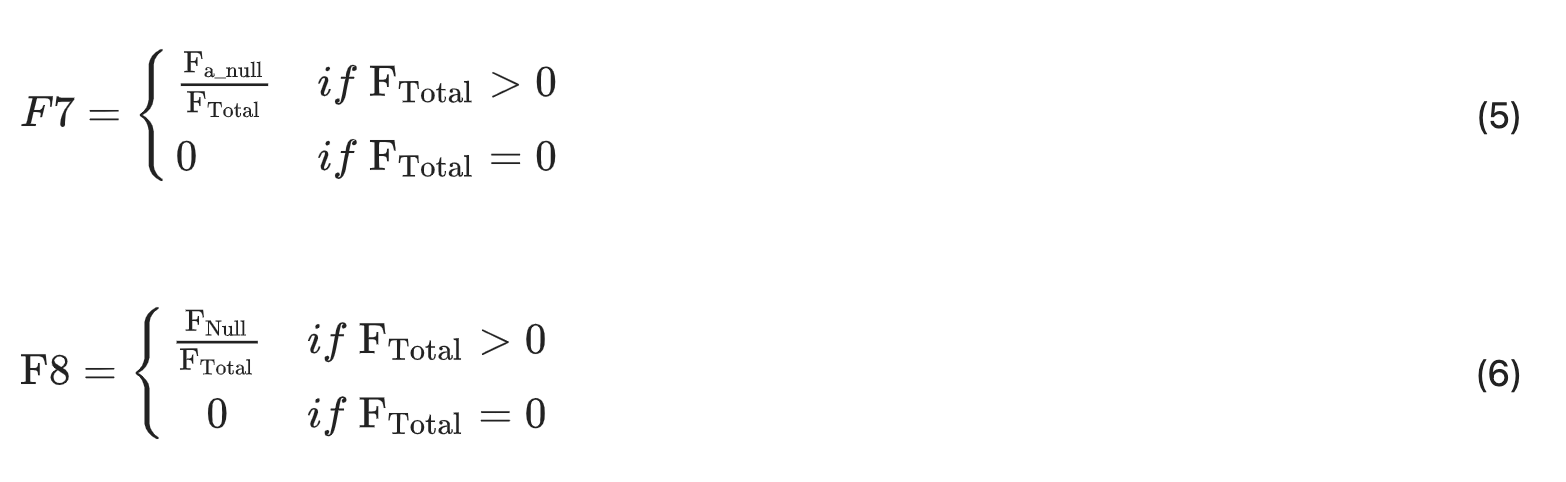

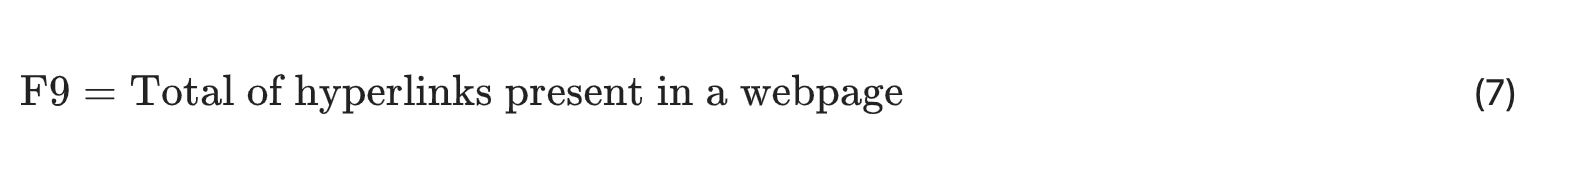

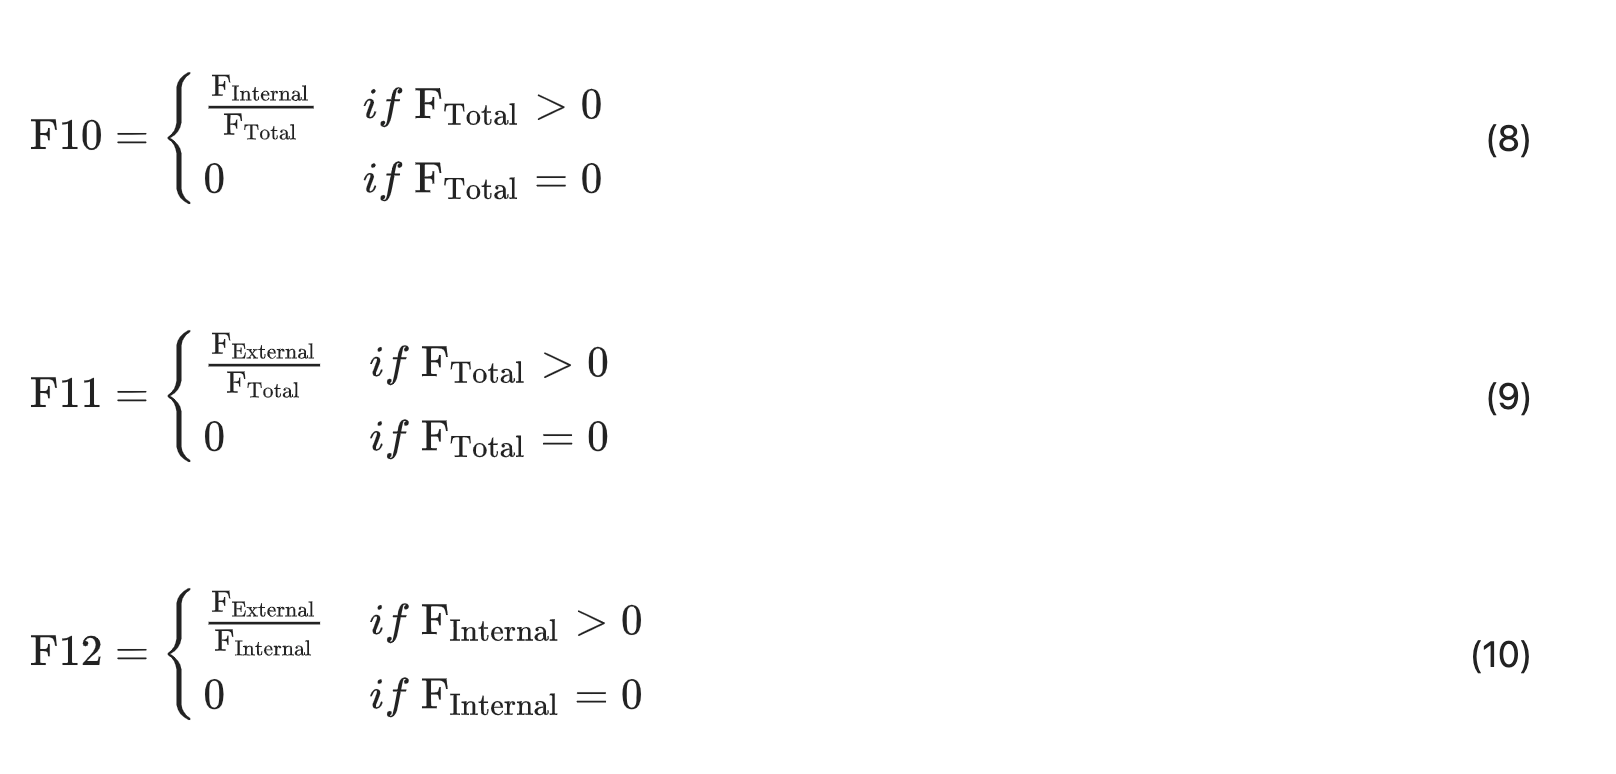

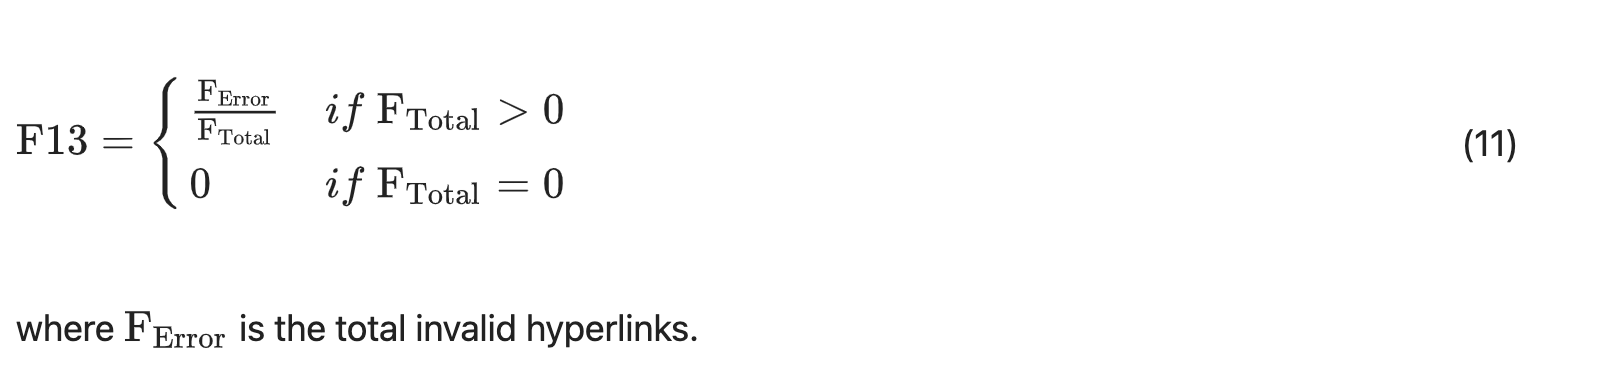

In [ ]:
# method to find number of a specific tag with attr present
def count_tags_with_attr(soup, tag, attr):
  return len(soup.find_all(tag, attrs={attr: True}))

# total
def count_total_hyperlinks(soup):
  # anchor, link, script, and img tags in the HTML (F9)
  # should we add count_tags_with_attr(soup, 'frame', 'src') + count_tags_with_attr(soup, 'form', 'action')
  return (count_tags_with_attr(soup, 'a', 'href') + count_tags_with_attr(soup, 'link', 'href') + count_tags_with_attr(soup, 'script', 'src') + count_tags_with_attr(soup, 'img', 'src')) + count_tags_with_attr(soup, 'frame', 'src') + count_tags_with_attr(soup, 'form', 'action')

# counting null and empty hyperlinks
def count_null_and_empty_hyperlinks(soup):
  null_patterns = ["#", "#content", "javaScript::void(0)", "javascript:;", ""]
  # link that takes nowhere
  null_hyperlinks = len([tag for tag in soup.find_all('a', href=True) if any(tag['href'].startswith(pattern) for pattern in null_patterns)])
  # does not halve the attr
  empty_anchors = len([tag for tag in soup.find_all('a') if not tag.has_attr('href')])
  return null_hyperlinks, empty_anchors

# think it is working now
def count_external_internal_hyperlinks(soup, base_domain):
    external_hyperlinks = 0
    internal_hyperlinks = 0

    for tag in soup.find_all(['a', 'link'], href=True):
        href = tag['href']
        if not href.startswith("http"):
            href = "https://"+href
        try:
            if urlparse(href).netloc and urlparse(href).netloc != base_domain:
                external_hyperlinks += 1
            elif urlparse(href).netloc == base_domain or not urlparse(href).netloc:
                internal_hyperlinks += 1
        except ValueError:
            continue

    for tag in soup.find_all(['script', 'img', 'frame'], src=True):
        src = tag['src']
        if not src.startswith("http"):
            src = "https://"+src
        try:
            if urlparse(src).netloc and urlparse(src).netloc != base_domain:
                external_hyperlinks += 1
            elif urlparse(src).netloc == base_domain or not urlparse(src).netloc:
                internal_hyperlinks += 1
        except ValueError:
            continue

    for tag in soup.find_all('form', action=True):
        action = tag.get('action')
        if action:
            if not action.startswith("http"):
                action = "https://"+action
            try:
                if urlparse(action).netloc and urlparse(action).netloc != base_domain:
                    external_hyperlinks += 1
                elif urlparse(action).netloc == base_domain or not urlparse(action).netloc:
                    internal_hyperlinks += 1
            except ValueError:
                continue

    return external_hyperlinks, internal_hyperlinks

# checking if a URL is valid
def is_valid_url(url):
  if not url.startswith("http"):
    url = "https://"+url
  try:
    result = urlparse(url)
    return bool(result.scheme)
  except ValueError:
    return False

# counting the urls in the 3 tag conditions
def count_invalid_hyperlinks(soup):
  invalid_count = 0
  for tag in soup.find_all(['a', 'link'], href=True):
    href = tag['href']
    if not is_valid_url(href):
      invalid_count += 1

  for tag in soup.find_all(['script', 'img', 'frame'], src=True):
    src = tag['src']
    if not is_valid_url(src):
        invalid_count += 1

  for tag in soup.find_all('form', action=True):
    action = tag['action']
    if not is_valid_url(action):
        invalid_count += 1
  return invalid_count

def count_forms_and_suspicious_forms(soup, base_domain):
  forms = soup.find_all('form')
  total_forms = len(forms)
  suspicious_forms = 0
  for form in forms:
    action = form.get('action')
    if action:  # Ensure action is not None
      if not action.startswith("http"):
        action = "https://"+action
      if action and is_valid_url(action) and (urlparse(action).netloc == base_domain):
        continue
      else:
        suspicious_forms += 1
  if (total_forms!=0):
    suspicious_forms = suspicious_forms/total_forms
  else:
    suspicious_forms = 0
  return total_forms, suspicious_forms

# Function to extract features
def extract_f(doc, base_domain):
  soup = BeautifulSoup(doc, 'html.parser')

  script_count = count_tags_with_attr(soup, 'script', 'src')
  css_count = count_tags_with_attr(soup, 'link', 'href')
  img_count = count_tags_with_attr(soup, 'img', 'src')
  anchor_count = count_tags_with_attr(soup, 'a', 'href')

  total_hyperlinks = count_total_hyperlinks(soup)

  null_hyperlinks, empty_anchors = count_null_and_empty_hyperlinks(soup)

  external_hyperlinks, internal_hyperlinks = count_external_internal_hyperlinks(soup, base_domain)

  invalid_hyperlinks = count_invalid_hyperlinks(soup)

  total_forms, suspicious_forms = count_forms_and_suspicious_forms(soup, base_domain)

  if total_hyperlinks == 0:
    F3 = F4 = F5 = F6 = F7 = F8 = F10 = F11 = F12 = F13 = 0
  else:
    F3 = script_count / total_hyperlinks
    F4 = css_count / total_hyperlinks
    F5 = img_count / total_hyperlinks
    F6 = anchor_count / total_hyperlinks
    F7 = empty_anchors / total_hyperlinks
    F8 = null_hyperlinks / total_hyperlinks
    F10 = internal_hyperlinks / total_hyperlinks
    F11 = external_hyperlinks / total_hyperlinks
    F12 = external_hyperlinks / internal_hyperlinks if internal_hyperlinks > 0 else 0
    F13 = invalid_hyperlinks / total_hyperlinks

  F9 = total_hyperlinks
  F14 = total_forms
  F15 = suspicious_forms / total_forms if total_forms > 0 else 0

  return F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15

def process_tags(directory):
  F1, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, Label = [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
  base = ""
  files = [f for f in os.listdir(directory) if f.endswith(".txt")]
  for filename in tqdm(files, desc="Processing files"):
      filepath = os.path.join(directory, filename)
      print(filepath)
      if filename.strip().split(".")[0] in id_url.ID.to_list():
          url_value = id_url[id_url.ID == filename.strip().split(".")[0]].URL.values[0].strip()
          print(url_value)
          if not url_value.startswith("http"):
              print("**")
              base = urlparse("https://"+url_value).netloc
              F1.append(list(extract_url_features(url_value)))
              Label.append(int((id_url[id_url.ID == filename.strip().split(".")[0]].Label.values[0]).strip()))
              with open(filepath, 'r', encoding='utf-8') as file:
                  html_doc = file.read()
                  temp1, temp2, temp3, temp4, temp5, temp6, temp7, temp8, temp9, temp10, temp11, temp12, temp13 = extract_f(html_doc, base)
                  F3.append(temp1)
                  F4.append(temp2)
                  F5.append(temp3)
                  F6.append(temp4)
                  F7.append(temp5)
                  F8.append(temp6)
                  F9.append(temp7)
                  F10.append(temp8)
                  F11.append(temp9)
                  F12.append(temp10)
                  F13.append(temp11)
                  F14.append(temp12)
                  F15.append(temp13)

  return F1, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, Label

# Example usage
directory = '/content/drive/My Drive/Phishing_project/test'  # Replace with the path to your directory containing .txt files
F1, F3, F4, F5, F6, F7, F8, F9, F10, F11, F12, F13, F14, F15, Label = process_tags(directory)

Processing files:   0%|          | 0/1 [00:00<?, ?it/s]

/content/drive/My Drive/Phishing_project/test/1111111111.txt
mytcbt.sbs/tcbt/
**


Processing files: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


In [ ]:
# validating the features: using -> bosch-climate.us
print("URL mat: "+ str(F1[0]))
print("Scirpt files: "+str(F3[0]))
print("CSS files: "+str(F4[0]))
print("Image files: "+str(F5[0]))
print("Anchor files: "+str(F6[0]))
print("Empty hyperlink: "+str(F7[0]))
print("Anchor missing href: "+str(F8[0]))
print("Total hyperlinks: "+str(F9[0]))
print("Internal hyperlinks: "+str(F10[0]))
print("External hyperlinks: "+str(F11[0]))
print("E/I hyperlinks: "+str(F12[0]))      # -> E/I
print("Error Hyperlinks: "+str(F13[0]))
print("Forms Total: "+str(F14[0]))
print("Sus forms: "+str(F15[0]))
print("Label: "+str(Label[0]))

URL mat: [13, 25, 20, 3, 2, 20, 65, 19, 2, 19, 71, 20, 3, 2, 20, 71, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Scirpt files: 0.1
CSS files: 0.6
Image files: 0.1
Anchor files: 0.1
Empty hyperlink: 0.0
Anchor missing href: 0.1
Total hyperlinks: 10
Internal hyperlinks: 0.2
External hyperlinks: 0.8
E/I hyperlinks: 4.0
Error Hyperlinks: 0.0
Forms Total: 1
Sus forms: 1.0
Label: 1


Legit website data:

Scirpt files: 0.04395604395604396

CSS files: 0.02564102564102564

Image files: 0.3992673992673993

Anchor files: 0.5311355311355311

Empty hyperlink: 0.003663003663003663

Anchor missing href: 0.0

Total hyperlinks: 273

Internal hyperlinks: 0.4908424908424908

External hyperlinks: 0.5091575091575091

I/E hyperlinks: 1.037313432835821

Error Hyperlinks: 0.0

Forms Total: 0

Sus forms: 0

In [ ]:
data = {
    'F1': F1,
    'F3': F3,
    'F4': F4,
    'F5': F5,
    'F6': F6,
    'F7': F7,
    'F8': F8,
    'F9': F9,
    'F10': F10,
    'F11': F11,
    'F12': F12,
    'F13': F13,
    'F14': F14,
    'F15': F15,
    'Label' : Label
}
super_df = pd.DataFrame(data)
print(super_df)

                                                  F1   F3   F4   F5   F6   F7  \
0  [13, 25, 20, 3, 2, 20, 65, 19, 2, 19, 71, 20, ...  0.1  0.6  0.1  0.1  0.0   

    F8  F9  F10  F11  F12  F13  F14  F15  Label  
0  0.1  10  0.2  0.8  4.0  0.0    1  1.0      1  


In [ ]:
super_df.to_csv("a.csv")

In [ ]:
file_path = '/content/drive/My Drive/Phishing_project/phish.csv'
super_df.to_csv(file_path, index=False)